In [5]:
!pip install scikit-learn==1.7.1


In [143]:
import pandas as pd

# Load CSV
df = pd.read_csv('reply_classification_dataset.csv')

# Basic info
print(df.head())
print(df.info())
print(df['label'].value_counts())


                                               reply     label
0                           Can we discuss pricing??   NEUTRAL
1  Im excited to explore this further, plz send c...  POSITIVE
2                We not looking for new solutions.    negative
3                 Could u clarify features included?   neutral
4           lets,, schedule a meeting to dive deeper  positive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   reply   2129 non-null   object
 1   label   2129 non-null   object
dtypes: object(2)
memory usage: 33.4+ KB
None
label
neutral     704
positive    446
NEGATIVE    267
POSITIVE    263
Negative    254
negative    189
Neutral       3
NEUTRAL       2
Positive      1
Name: count, dtype: int64


In [144]:
df.isnull().sum()

reply    0
label    0
dtype: int64

## Preprocessing

In [145]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # remove urls
    text = re.sub(r"[^a-z\s]", "", text)  # remove punctuation and numbers
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

df['clean_text'] = df['reply'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\himan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [146]:
# Normalize labels to avoid case-variant duplicates (e.g., 'positive' vs 'POSITIVE')
df['label'] = df['label'].astype(str).str.strip().str.upper()
print("Label distribution after normalization:\n", df['label'].value_counts())

Label distribution after normalization:
 label
POSITIVE    710
NEGATIVE    710
NEUTRAL     709
Name: count, dtype: int64


In [147]:
# Drop exact duplicates by cleaned text to reduce leakage and variance
before = len(df)
df = df.drop_duplicates(subset=['clean_text']).reset_index(drop=True)
after = len(df)
print(f"Deduplicated clean_text: dropped {before - after} rows; remaining: {after}")

Deduplicated clean_text: dropped 1828 rows; remaining: 301


In [148]:
# Refresh X and y after label normalization (robust to missing clean_text)
try:
    X = df['clean_text']
except KeyError:
    X = df['reply'].astype(str)

y = df['label']
print("Classes after normalization:", sorted(y.unique()))
print("Using X column:", 'clean_text' if 'clean_text' in df.columns else 'reply')

Classes after normalization: ['NEGATIVE', 'NEUTRAL', 'POSITIVE']
Using X column: clean_text


## Split Dataset

In [149]:
from sklearn.model_selection import GroupShuffleSplit

# Use cleaned text and group-aware split so duplicates don't leak across train/test
X = df['reply']
y = df['label']
groups = df['reply']  # group duplicates by identical cleaned text

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [150]:
#convert text to numerical data using TF-IDF with sublinear TF (log scaling)
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, sublinear_tf=True, norm='l2')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [151]:
import joblib

joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

## Using SVM for the first Model

In [152]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report

svm_model = SVC(kernel='linear', probability=True, random_state=42)

svm_model.fit(X_train_vec, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [153]:
y_pred_svm = svm_model.predict(X_test_vec)

In [154]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM F1 Score:", f1_score(y_test, y_pred_svm, average='weighted'))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.9836065573770492
SVM F1 Score: 0.9835707833615054

SVM Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       1.00      1.00      1.00        18
     NEUTRAL       1.00      0.95      0.97        20
    POSITIVE       0.96      1.00      0.98        23

    accuracy                           0.98        61
   macro avg       0.99      0.98      0.98        61
weighted avg       0.98      0.98      0.98        61



In [155]:
import joblib

joblib.dump(svm_model, "svm_model.pkl")

['svm_model.pkl']

## =====RANDOM FOREST=======

In [156]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_vec, y_train)




,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [157]:
y_pred_rf = rf_model.predict(X_test_vec)

In [158]:
# Grouped Cross-Validation for SVM and RandomForest (prevents duplicate leakage)
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Build pipelines on raw cleaned text
svm_pipe = make_pipeline(
    TfidfVectorizer(max_features=5000, sublinear_tf=True, norm='l2'),
    LinearSVC(random_state=42)  # faster than SVC(probability=True)
)

rf_pipe = make_pipeline(
    TfidfVectorizer(max_features=5000, sublinear_tf=True, norm='l2'),
    RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
)

# Grouped CV by identical cleaned text
groups = df['clean_text']
gcv = GroupKFold(n_splits=5)

for name, pipe in [("SVM", svm_pipe), ("RF", rf_pipe)]:
    acc = cross_val_score(pipe, df['clean_text'], df['label'], cv=gcv, groups=groups, scoring='accuracy', n_jobs=-1)
    f1w = cross_val_score(pipe, df['clean_text'], df['label'], cv=gcv, groups=groups, scoring='f1_weighted', n_jobs=-1)
    print(f"{name} 5-fold Grouped-CV Accuracy: {acc.mean():.4f} ± {acc.std():.4f}")
    print(f"{name} 5-fold Grouped-CV F1 (weighted): {f1w.mean():.4f} ± {f1w.std():.4f}")

SVM 5-fold Grouped-CV Accuracy: 0.9734 ± 0.0134
SVM 5-fold Grouped-CV F1 (weighted): 0.9735 ± 0.0131
RF 5-fold Grouped-CV Accuracy: 0.9567 ± 0.0227
RF 5-fold Grouped-CV F1 (weighted): 0.9569 ± 0.0228
RF 5-fold Grouped-CV Accuracy: 0.9567 ± 0.0227
RF 5-fold Grouped-CV F1 (weighted): 0.9569 ± 0.0228


In [159]:
import joblib

joblib.dump(rf_model, "randomForest_model.pkl")

['randomForest_model.pkl']

In [160]:
import joblib

# Save updated vectorizer with sublinear TF
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [161]:
dups = df.duplicated('clean_text').sum()
print("Duplicate texts (clean_text):", dups)


Duplicate texts (clean_text): 0


## Learning Graphs


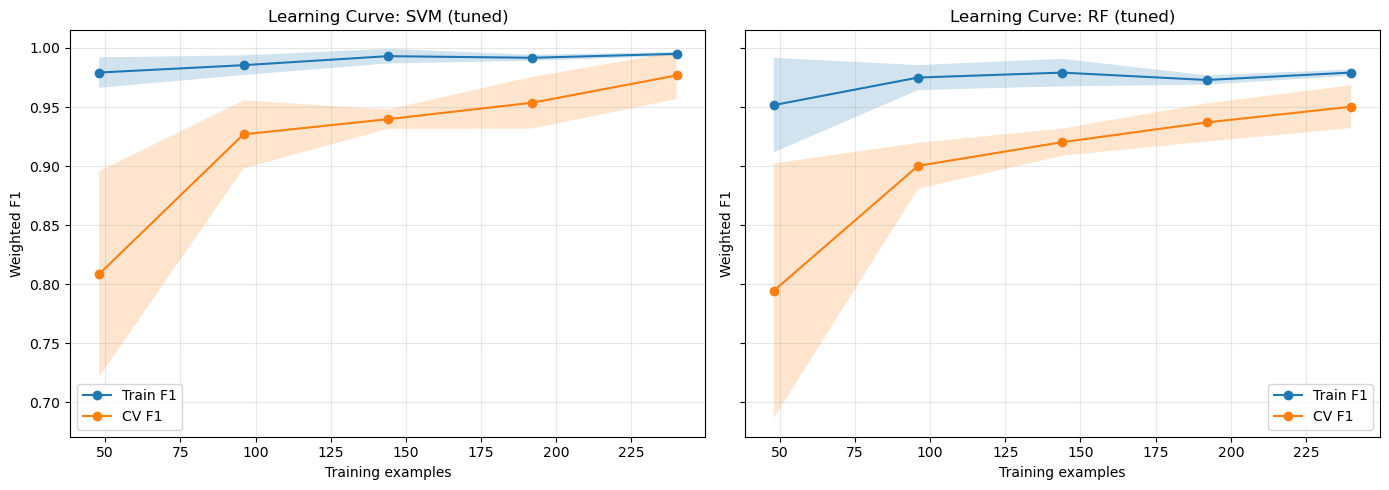

In [162]:
# Tuned learning curves (stronger regularization and feature pruning)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, GroupKFold
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

svm_tuned = make_pipeline(
    TfidfVectorizer(min_df=3, max_df=0.85, max_features=3000, ngram_range=(1,1), sublinear_tf=True, norm='l2'),
    LinearSVC(C=0.5, random_state=42)
)
rf_tuned = make_pipeline(
    TfidfVectorizer(min_df=3, max_df=0.85, max_features=3000, ngram_range=(1,1), sublinear_tf=True, norm='l2'),
    RandomForestClassifier(
        n_estimators=400, max_depth=30, min_samples_leaf=2,
        max_features='sqrt', random_state=42, n_jobs=-1
    )
)

X_c = df['reply']
y_c = df['label']
groups = df['clean_text']
cv = GroupKFold(n_splits=5)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for ax, (name, pipe) in zip(axes, [("SVM (tuned)", svm_tuned), ("RF (tuned)", rf_tuned)]):
    train_sizes, train_scores, val_scores = learning_curve(
        pipe, X_c, y_c, groups=groups, cv=cv,
        scoring='f1_weighted', n_jobs=-1,
        train_sizes=np.linspace(0.2, 1.0, 5),
        shuffle=True, random_state=42
    )
    tr_mean, tr_std = train_scores.mean(axis=1), train_scores.std(axis=1)
    va_mean, va_std = val_scores.mean(axis=1), val_scores.std(axis=1)

    ax.plot(train_sizes, tr_mean, 'o-', label='Train F1')
    ax.fill_between(train_sizes, tr_mean-tr_std, tr_mean+tr_std, alpha=0.2)
    ax.plot(train_sizes, va_mean, 'o-', label='CV F1')
    ax.fill_between(train_sizes, va_mean-va_std, va_mean+va_std, alpha=0.2)
    ax.set_title(f"Learning Curve: {name}")
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Weighted F1")
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()


In [163]:
# Persist tuned pipelines for deployment
import joblib

artifacts = []
try:
    # Prefer tuned pipelines if available in the session
    if 'svm_tuned' in globals() and svm_tuned is not None:
        joblib.dump(svm_tuned, 'svm_best_pipeline.pkl')
        artifacts.append('svm_best_pipeline.pkl')
    elif 'svm_best' in globals() and svm_best is not None:
        joblib.dump(svm_best, 'svm_best_pipeline.pkl')
        artifacts.append('svm_best_pipeline.pkl')
except Exception as e:
    print(f"Warning: could not persist SVM pipeline: {e}")

try:
    if 'rf_tuned' in globals() and rf_tuned is not None:
        joblib.dump(rf_tuned, 'rf_best_pipeline.pkl')
        artifacts.append('rf_best_pipeline.pkl')
    elif 'rf_pipe' in globals() and rf_pipe is not None:
        joblib.dump(rf_pipe, 'rf_best_pipeline.pkl')
        artifacts.append('rf_best_pipeline.pkl')
except Exception as e:
    print(f"Warning: could not persist RF pipeline: {e}")

print('Saved artifacts:', artifacts if artifacts else 'None')

Saved artifacts: ['svm_best_pipeline.pkl', 'rf_best_pipeline.pkl']
